In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, f1_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, Input
from sklearn.preprocessing import StandardScaler

C:\Users\mateu\AppData\Local\Temp\ipykernel_3240\2904441274.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your dataframe
df = pd.read_csv('creditcard.csv')

scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

X = df.drop('Class', axis=1).values
y = df['Class'].values

# Perform undersampling
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

undersample_indices = np.random.choice(class_0_indices, size=len(class_1_indices), replace=False)
undersample_indices = np.concatenate([undersample_indices, class_1_indices])

X = X[undersample_indices]
y = y[undersample_indices]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reshape the data for the Conv1D layer
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

In [3]:
# Combinations of activation functions to test, including Leaky ReLU
activations_list = [
    ('relu', 'relu','relu', 'sigmoid'),
    ('leaky_relu','leaky_relu', 'leaky_relu', 'sigmoid'),
    ('sigmoid', 'sigmoid','sigmoid', 'sigmoid'),
    ('relu', 'relu','relu', 'tanh'),
    ('leaky_relu', 'leaky_relu','leaky_relu', 'tanh'),
    ('tanh', 'tanh','tanh', 'tanh'),
    ('linear','linear', 'linear', 'sigmoid')
]

# Dictionary to store results
results = {'activation_combination': [], 'auprc': [], 'f1_score': [], 'precision': [], 'recall': []}


In [4]:
# Function to add layers with activation functions including leaky_relu
def add_dense_layer(model, units, activation):
    if activation == 'leaky_relu':
        model.add(Dense(units))
        model.add(LeakyReLU(negative_slope=0.01))
    else:
        model.add(Dense(units, activation=activation))

def add_conv1d_layer(model, filters, kernel_size, activation, input_shape=None):
    if input_shape:
        if activation == 'leaky_relu':
            model.add(Conv1D(filters=filters, kernel_size=kernel_size, input_shape=input_shape))
            model.add(LeakyReLU(negative_slope=0.01))
        else:
            model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=input_shape))
    else:
        if activation == 'leaky_relu':
            model.add(Conv1D(filters=filters, kernel_size=kernel_size))
            model.add(LeakyReLU(negative_slope=0.01))
        else:
            model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))

# Loop through each activation combination
for activations in activations_list:
    # Define the CNN model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    add_conv1d_layer(model, filters=64, kernel_size=2, activation=activations[0])
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    add_conv1d_layer(model, filters=128, kernel_size=2, activation=activations[1])
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    model.add(Flatten())
    add_dense_layer(model, units=128, activation=activations[2])
    model.add(Dropout(0.5))

    add_dense_layer(model, units=1, activation=activations[3])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['precision', 'recall'])

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val), verbose=1)

    # Predict probabilities and classes for the validation set
    y_val_pred_prob = model.predict(X_val).ravel()
    y_val_pred_class = (y_val_pred_prob > 0.5).astype(int)

    # Calculate precision-recall curve and AUPRC
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred_prob)
    auprc = auc(recall, precision)

    # Calculate F1 score
    f1 = f1_score(y_val, y_val_pred_class)

    # Store results
    results['activation_combination'].append(activations)
    results['auprc'].append(auprc)
    results['f1_score'].append(f1)
    results['precision'].append(precision)
    results['recall'].append(recall)

    # Save the model
    #model_name = f"CNNmodel_{activations[0]}_{activations[1]}_{activations[3]}.keras"
    #model.save(model_name)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.6909 - precision: 0.6982 - recall: 0.7555 - val_loss: 0.7677 - val_precision: 0.4975 - val_recall: 1.0000
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3179 - precision: 0.9467 - recall: 0.8770 - val_loss: 0.6876 - val_precision: 0.5026 - val_recall: 1.0000
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2609 - precision: 0.9082 - recall: 0.8971 - val_loss: 0.5509 - val_precision: 0.5537 - val_recall: 1.0000
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2404 - precision: 0.9107 - recall: 0.8903 - val_loss: 0.4494 - val_precision: 0.6443 - val_recall: 0.9796
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2110 - precision: 0.9359 - recall: 0.9028 - val_loss: 0.3848 - val_precision: 0.7705 - val_recall: 0.9592
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2051 - precision: 0.9310 - recall: 0.9028 - val_loss: 0.3399 - val_precision: 0.8319 - val_recall: 0.9592
Epoc

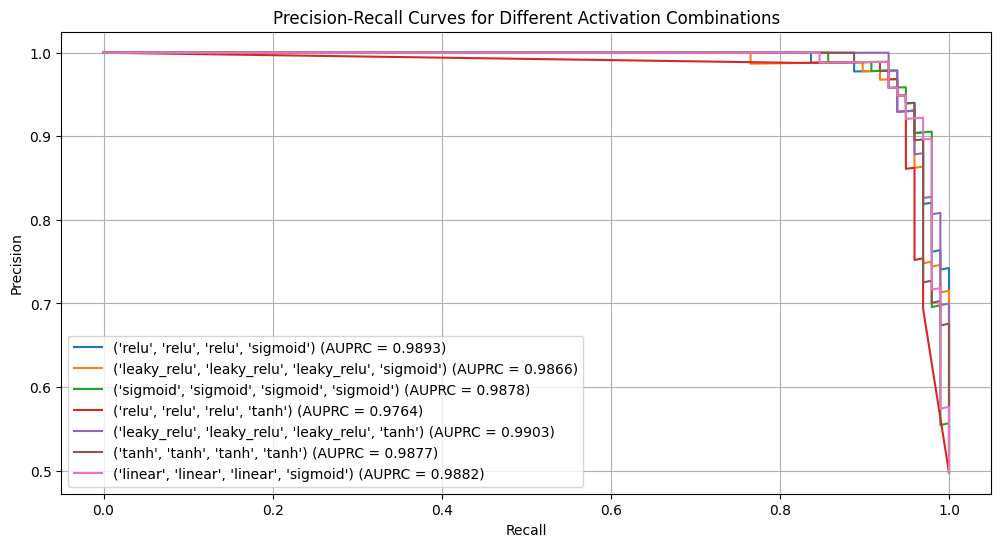

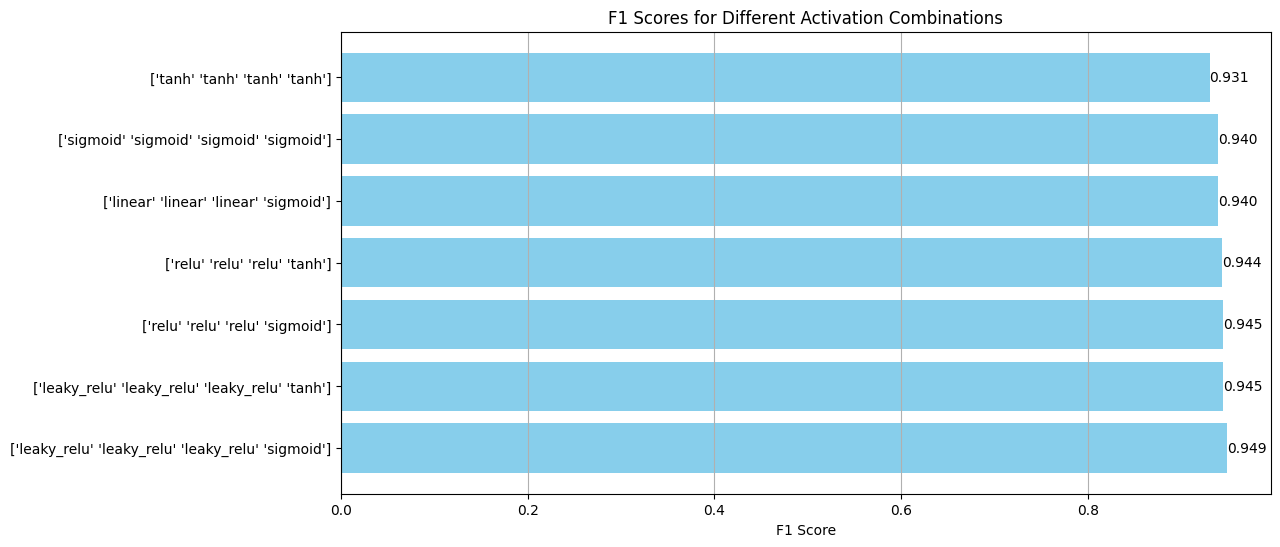

In [12]:
# Plotting all AUPRC curves
plt.figure(figsize=(12, 6))
for i in range(len(activations_list)):
    plt.plot(results['recall'][i], results['precision'][i], label=f'{results["activation_combination"][i]} (AUPRC = {results["auprc"][i]:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Different Activation Combinations')
plt.legend()
plt.grid()
plt.show()

# Sort the F1 scores and activation combinations in descending order
sorted_indices = np.argsort(results['f1_score'])[::-1]
sorted_f1_scores = np.array(results['f1_score'])[sorted_indices]
sorted_activation_combinations = np.array(results['activation_combination'])[sorted_indices]

# Plot F1 scores
plt.figure(figsize=(12, 6))
bars = plt.barh([str(a) for a in sorted_activation_combinations], sorted_f1_scores, color='skyblue')
plt.xlabel('F1 Score')
plt.title('F1 Scores for Different Activation Combinations')
plt.grid(axis='x')

# Annotate each bar with its F1 score value
for i, bar in enumerate(bars):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{sorted_f1_scores[i]:.3f}', 
             va='center', ha='left', color='black')

plt.show()

